# Setup and Imports

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import re
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.corpus import wordnet
from nltk.corpus import words
import enchant
from collections import Counter
import spacy
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer

# Download the Data from Kaggle

In [2]:
#Create the API to interact with Kaggle
api = KaggleApi()
#Authenticate using API credentials
api.authenticate()

In [5]:
#Download the competition files
api.competition_download_files('nlp-getting-started')
#Open the zip file
zf = ZipFile('nlp-getting-started.zip')
#Extract the files and specify the location
zf.extractall("data\\") 
#Close the zip file
zf.close()

# Read in the Training Data

In [2]:
tweets = pd.read_csv("data/train.csv")

In [3]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets.drop(["id", "keyword", "location"], axis = 1, inplace=True)

In [5]:
tweets.isnull().sum()

text      0
target    0
dtype: int64

# Data Preprocessing and Normalization

In [6]:
def strip_html_tags(text):
    """
    This function removes unnecessary HTML tags in the corpus. 
    
    test: corpus of text data
    
    returns: text with no HTML

    """
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(["iframe", "script"])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    
    return stripped_text

In [7]:
def text_tokenizer(text):
    """
    This function takes a corpus and tokenizes it into sentences
    Parameters
    
    test: String containing the corpus
    
    returns: Corpus of tokenized sentences

    """
    tokenizer = nltk.sent_tokenize
    sentence_tokens = tokenizer(text=text)
    return sentence_tokens 


In [8]:
def word_tokenizer(text):
    """
    This function takes a corpus and splits the sentences into words
    
    test: String of tokenized sentences
    
    returns: Array of tokenized words

    """
    tokenizer = nltk.word_tokenize
    word_tokens = tokenizer(text)
    return np.array(word_tokens)


In [9]:
def remove_accented_chars(text):
    """
    This function removes accented characters from the corpus using ASCII
    characters
    
    text: String corpus of text data
    
    returns: Corpus with all characters converted and standardized into ASCII characters

    """
    
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [10]:
#This map was gotten from the internet

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"}

def expand_contractions(text, contraction_mapping = CONTRACTION_MAP):
    """
    This function takes a corpus of text data and expands all contractions
    bassed on the contraction mapping
    
    text: String corpus of text data
    
    returns: Text corpus with all contractions expanded

    """
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [11]:
def remove_special_characters(text, remove_digits = False):
    """
    This function returns the text corpus with all special characters removed with the option
    to remove digits
    
    text: String corpus
    
    returns: Text corpus with special characters removed

    """
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [12]:
def case_conversation(text, text_lower = True):
    """
    This function returns the corpus with all tokens lowercase or uppercase
    
    text: String corpus
    text_lower: Boolen, default is True
    
    returns: Text corpus with all tokens converted

    """
    if text_lower:
        return text.lower()
    else:
        return text.upper()

In [13]:
nlp = spacy.load('en_core_web_sm')
def lemmatize(text):
    """
    This function returns the lemmatized text corpus. Gives correct spelling. 

    text: String corpus
    
    returns: String of lemmatized text corpus
    """
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [14]:
def remove_stopwords(text, is_lower_case=False):
    """
    This function removes all the stopwords from the text corpus based on the pre-existing 
    list of stopwords from nltk. 
    
    text: String corpus
    is_lower_case: Boolean to make the corpus lower case
    
    returns: String corpus with stopwords removed

    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [15]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def normalize_corpus(corpus, html_stripping = True, contraction_expansion = True, accented_char_removal = True, 
                     text_lower_case = True, text_lemmatization = True, special_char_removal = True, stopword_removal=True, 
                     remove_digits = True):
    """
    This function normalizes the text corpus based on all the functions above. 

    corpus : Text corpus
    html_stripping : boolean, optional
        Controls if the text corpus is stripped of htmls
    contraction_expansion : boolean, optional
        Controls if the text corpus has its contractions extraction
    accented_char_removal : boolean, optional
        Controls if the text corpus has its accented characters removed
    text_lower_case : boolean, optional
        Controls if the text corpus has its text changed to lower case
    correct_spelling : boolean, optional
        Controls if the text corpus has its spelling corrected
    text_lemmatization : boolean, optional
        Controls if the text corpus his its words lemmatized
    special_char_removal : boolean, optional
        Controls if the text corpus has its special characters removed
    stopword_removal : boolean, optional
        Controls if the text corpus has its stopwords removed
    remove_digits : boolean, optional
        Controls if the text corpus has its digits removed

    returns: String of normalized text corpus
    """
    
    normalized_corpus = []

    for doc in corpus:
        
        if html_stripping:
            doc = strip_html_tags(doc)
            
        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        if contraction_expansion:
            doc = expand_contractions(doc)
            
        if text_lower_case:
            doc = case_conversation(doc)
            
        #Remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
            
        if text_lemmatization:
            doc = lemmatize(doc)
            
        if special_char_removal:
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
            
        #Removes extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

### Normalize the Corpus of Tweets

In [16]:
%%time
stopword_list.remove("no")
stopword_list.remove("not")

corpus = tweets["text"]
norm_corpus = np.array(normalize_corpus(corpus))

tweets["Clean Tweets"] = norm_corpus

Wall time: 1min 27s


In [18]:
pd.set_option('display.max_colwidth', 2)
tweets.head(n=10)

,text,target,Clean Tweets
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer no evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got send photo ruby alaska smoke wildfire pour school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,rockyfire update california hwy close direction due lake county fire cafire wildfire
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,flood disaster heavy rain cause flash flooding street manitou colorado spring area
7,I'm on top of the hill and I can see a fire in the woods...,1,I top hill I see fire wood
8,There's an emergency evacuation happening now in the building across the street,1,emergency evacuation happen building across street
9,I'm afraid that the tornado is coming to our area...,1,I afraid tornado come area


Check if normalizing resulted in any rows having a missing value

In [20]:
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
tweets.isnull().sum()

text          0
target        0
Clean Text    0
dtype: int64

## Analyze Word Occurence in Safe Tweets

### Analyze the most common words

In [77]:
# Create a list of all words used in safe tweets
words = [word for row in tweets["Clean Tweets"] for word in row.split()]
# Create a counter to count the words
word_cnt = Counter(words)
# Create a dictionary of the words
word_dict = dict(word_cnt.most_common())
# Create a dataframe with words and their count
word_df = pd.DataFrame({"Word": word_dict.keys(), "Count": word_dict.values()})
# Create a new column with the word percentage
word_df["Percentage"] = (word_df["Count"] / len(words)) * 100
word_df.head(n=10)

,Word,Count,Percentage
0,httpt,4307,5.244764
1,I,2104,2.562104
2,not,754,0.918169
3,_,423,0.515100
4,httpst,409,0.498052
5,like,395,0.481003
6,get,375,0.456649
7,fire,359,0.437165
8,go,276,0.336094
9,no,266,0.323916


In [30]:
#How many unique "words" are in the data
word_df.shape[0]

18954

Text(0.5, 1.0, 'Top 30 Words By Percentage')

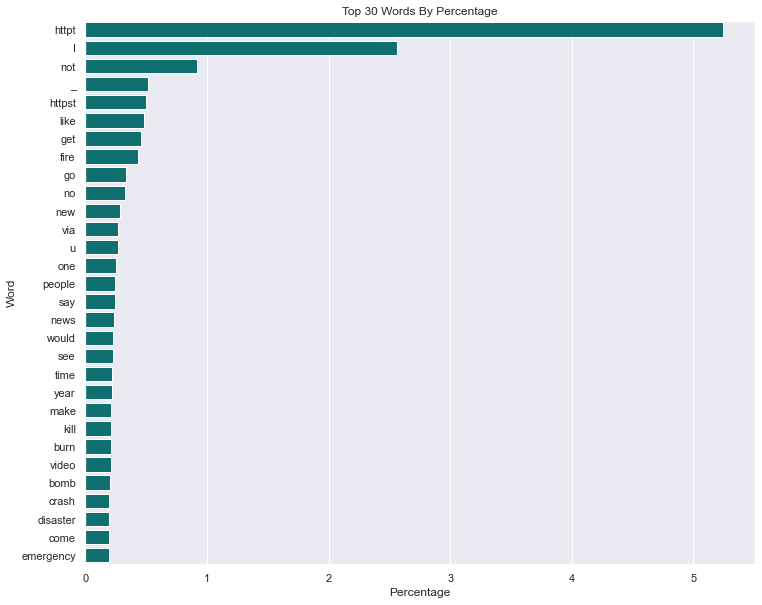

In [22]:
#Plot the top 30 words ranked by their percentage
sns.set(rc = {'figure.figsize':(12,10)})
sns.barplot(x="Percentage", y="Word", data = word_df[:30], color = "teal")
plt.title("Top 30 Words By Percentage")

In [72]:
word_grp_df = pd.DataFrame(word_df["Count"]\
                                           .value_counts()\
                                           .reset_index()\
                                           .rename(columns={"index": "Word Occurrence", "Count" :"Number of Words"}))\
                                            .sort_values(by="Word Occurrence")
word_grp_df[["Number of Words", "Word Occurrence"]]

,Number of Words,Word Occurrence
0,13456,1
1,1785,2
2,793,3
3,512,4
4,371,5
...,...,...
137,1,409
144,1,423
120,1,754
134,1,2104


In [24]:
word_df.loc[word_df["Count"] == 1].head(n=20)

,Word,Count,Percentage
5498,ronge,1,0.001218
5499,sask,1,0.001218
5500,notify,1,0.001218
5501,ruby,1,0.001218
5502,manitou,1,0.001218
5503,fvck,1,0.001218
5504,tampabay,1,0.001218
5505,goooooooaaaaaal,1,0.001218
5506,skiing,1,0.001218
5507,looooool,1,0.001218


We see some of these words are either mispellings such as "cooool" and "fvck" while some are giberish. We'll go ahead and remove all words that are giberish. We'll do this by removing words that don't appear in nltk's wordnet corpus and those words that are not spelled correctly determine by PyEnchant.

In [78]:
spell_checker = enchant.Dict("en_US")
spell_checker.check("would")

def valid_word(text):
    correct_word = (len(wordnet.synsets(text)) != 0 & spell_checker.check(text))
    return correct_word

In [79]:
word_df["Valid Word"] = word_df["Word"].apply(valid_word)

In [80]:
word_df["Valid Word"].value_counts()

False    11473
True     7481 
Name: Valid Word, dtype: int64

In [92]:
#Words that don't appear in wordnet or don't appear to be spelled correctly
word_df.loc[(word_df["Valid Word"] == False)]

,Word,Count,Percentage,Valid Word
0,httpt,4307,5.244764,False
3,_,423,0.515100,False
4,httpst,409,0.498052,False
11,via,220,0.267901,False
17,would,187,0.227716,False
...,...,...,...,...
18948,forney,1,0.001218,False
18950,corqkkuhey,1,0.001218,False
18951,conficuloje,1,0.001218,False
18952,costfmbbzfb,1,0.001218,False


In [90]:
word_df.loc[(word_df["Valid Word"] == True) & (word_df["Count"] == 10)]

,Word,Count,Percentage,Valid Word
1242,perfect,10,0.012177,True
1243,quite,10,0.012177,True
1244,weird,10,0.012177,True
1245,church,10,0.012177,True
1246,able,10,0.012177,True
...,...,...,...,...
1321,municipal,10,0.012177,True
1323,veteran,10,0.012177,True
1325,combo,10,0.012177,True
1327,sinking,10,0.012177,True


In [100]:
def remove_words(text):
    new_string = re.sub(r'(httpst )|(_ )|(httpt )', '', text)
    return new_string

In [94]:
string = "This is a test"
string_lst = list(string.split())
string_lst

['This', 'is', 'a', 'test']

In [95]:
string2 = ' '.join(string_lst)

In [96]:
string2

'This is a test'

In [98]:
bad_words = list(word_df.loc[(word_df["Valid Word"] == False), "Word"])
bad_words[:5]

['httpt', '_', 'httpst', 'via', 'would']

In [99]:
len(bad_words)

11473

In [105]:
new_string = re.sub("a|test", '', string2)
new_string

'This is  '

In [326]:
def make_pattern(word_list):
    string = [word if word != "[" and word != "]" else "\\" + word for word in word_list]
    string = '|'.join(string)
    return string

In [ ]:
[unicode(x.strip()) if x is not None else '' for x in row]

In [327]:
long_str = """It won't work well with WordNet, because WordNet does not contain all english words. 
Another possibility based on NLTK without enchant is NLTK's words corpus"""

temp = ["work", "well", "does", "all", "is", "si", "]"]

pat = make_pattern(temp)
pat

'work|well|does|all|is|si|\\]'

In [328]:
def remove_words(text, pattern):
    re.compile(pattern)
    #new_string = re.sub(pattern, ' ', text)
    new_string = re.sub(pattern, '', text)
    return new_string

In [329]:
remove_words(long_str, pat)

"It won't   with WordNet, because WordNet  not contain  englh words. \nAnother posbility based on NLTK without enchant  NLTK's words corpus"

In [154]:
word_df.head()

,Word,Count,Percentage,Valid Word
0,httpt,4307,5.244764,False
1,I,2104,2.562104,True
2,not,754,0.918169,True
3,_,423,0.515100,False
4,httpst,409,0.498052,False


In [330]:
bad_words_list = list(word_df.loc[(word_df["Valid Word"] == False), "Word"])
bad_words_list.index("famine[")
bad_words_list[bad_words_list.index("famine[")] = "famine\["

In [331]:
bad_words = make_pattern(bad_words_list)

In [332]:
bad_words[:40]

'httpt|_|httpst|via|would|\\[|\\]|rt|youtub'

In [333]:
#tester = "This httpt is a test to make would sure the function actually works"
tester = "httpt"
remove_words(tester, bad_words[:40])

''

In [224]:
test = "word"
re.sub("word", '', test)

''

In [334]:
word_df["Correct Words"] = word_df["Word"].apply(remove_words, pattern = bad_words)

In [338]:
word_df.loc[(word_df["Valid Word"] == False) & (word_df["Correct Words"] != '')].head(30)

,Word,Count,Percentage,Valid Word,Correct Words
624,reuter,23,0.028008,False,ter
1386,app,9,0.010960,False,p
1463,steve,8,0.009742,False,eve
1631,worldnew,7,0.008524,False,dnew
1743,mhtwfnet,7,0.008524,False,tw
1964,gta,6,0.007306,False,a
2022,yazidi,6,0.007306,False,z
2283,summerfate,5,0.006089,False,mmerfate
2319,strategicpatience,5,0.006089,False,rategicpatience
2346,worldnews,5,0.006089,False,dnews


In [344]:
bad_words_list.index("reuter")
bad_words_list[30:36]

['soudelor', 'hey', 'anyone', 'bestnaijamade', 'reuter', 'everything']

In [346]:
bad_words[190:230]

'tnaijamade|reuter|everything|amid|nowpla'

In [357]:
tweets.loc[tweets["Clean Tweets"]]

AttributeError: 'str' object has no attribute 'isin'

In [354]:
"work" in temp

True